In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from tqdm.auto import tqdm
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
df_initial = pd.read_csv(
        "data/data.csv",
        encoding="ISO-8859-1",
        dtype={"CustomerID": str, "InvoiceID": str},
        parse_dates=["InvoiceDate"],
    )


In [4]:
df_initial.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

### Remove Missing values


In [5]:
# CustomerID is missing 25% time.
# For simplicity, we remove those entries, with possible solution stated later in README.md
df_initial.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [6]:
df_initial = df_initial[~df_initial["CustomerID"].isna()]
df_initial.isna().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

### Remove Duplicates


In [7]:
original_size = len(df_initial)
df_initial = df_initial.drop_duplicates()
new_size = len(df_initial)

print(f"Removed [{original_size - new_size}/{original_size}]")

Removed [5225/406829]


# Countries distribution

In [8]:
temp = (
    df_initial[["CustomerID", "InvoiceNo", "Country"]]
    .groupby(["CustomerID", "InvoiceNo", "Country"])
    .count()
)
temp = temp.reset_index(drop=False)
countries = temp["Country"].value_counts()

print("Number of countries in the dataframe: {}".format(len(countries)))

Number of countries in the dataframe: 37


In [9]:
data = dict(
    type="choropleth",
    locations=countries.index,
    locationmode="country names",
    z=countries,
    text=countries.index,
    colorbar={"title": "Order nb."},
    colorscale=[
        [0, "rgb(224,255,255)"],
        [0.01, "rgb(166,206,227)"],
        [0.02, "rgb(31,120,180)"],
        [0.03, "rgb(178,223,138)"],
        [0.05, "rgb(51,160,44)"],
        [0.10, "rgb(251,154,153)"],
        [0.20, "rgb(255,255,0)"],
        [1, "rgb(227,26,28)"],
    ],
    reversescale=False,
)
# _______________________
layout = dict(
    title="Number of orders per country",
    geo=dict(showframe=True, projection={"type": "mercator"}),
)
# ______________
choromap = go.Figure(data=[data], layout=layout)
iplot(choromap, validate=False)

### Transaction analysis

In [10]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


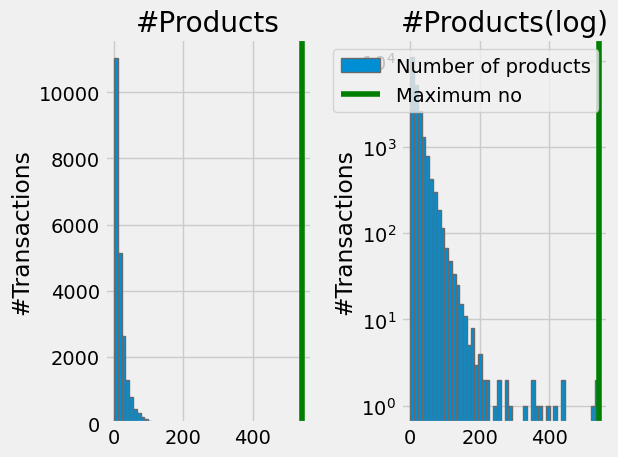

In [11]:
temp = df_initial.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[
    "InvoiceDate"
].count()
nb_products_per_basket = temp.rename(columns={"InvoiceDate": "Number of products"})


fig, axes = plt.subplots(1, 2)

nb_products_per_basket["Number of products"].plot(kind="hist", bins=50, ax=axes[0])
axes[0].axvline(x=nb_products_per_basket["Number of products"].max(), label="Maximum no", color="green")
axes[0].set_title("#Products")
axes[0].set_ylabel("#Transactions")

nb_products_per_basket["Number of products"].plot(kind="hist", bins=50, ax=axes[1])
axes[1].set_title("#Products(log)")
axes[1].set_ylabel("#Transactions")
axes[1].axvline(x=nb_products_per_basket["Number of products"].max(), label="Maximum no", color="green")
axes[1].set_yscale("log")

fig.tight_layout()
plt.legend()
plt.show()

In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


# Bundle Analysis

In [13]:
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
...,...,...,...,...
22185,18283,579673,50,0
22186,18283,580872,50,0
22187,18287,554065,29,0
22188,18287,570715,38,0
